In [19]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import random

random.seed(1)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
        
csv_collection = []
for dirname, _, filenames in os.walk('/kaggle/input/'):
    for filename in filenames:
        fullpath = os.path.join(dirname, filename)
        csv_collection.append(fullpath)

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version 
# using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [20]:
len(csv_collection) # 299 days of data

300

# Get data

In [21]:
df_list_feb = []
df_list_may = []
df_list_sep = []
df_list_russia = []
df_list_ukraine = []
df_list_us = []

n = 1400 # Number of samples each day

for file_name in csv_collection:
    df = pd.read_csv(file_name, compression='gzip')
    
    # Only include english tweets
    df = df[(df['language'] == 'en')]
    
    # Remove duplicates, i.e., retweets
    df = df.drop_duplicates(subset='text')
    
    # Extract the data from the DataFrame based on the location column
    df_russia = df.loc[df['location'] == 'Russia']
    df_ukraine = df.loc[df['location'] == 'Ukraine']
    df_us = df.loc[df['location'] == 'United States']
        
    # Extract the data from the DataFrame based on the tweetcreatedts column
    df = df.sample(n=n)

    df_feb = df.loc[df['tweetcreatedts'] <= '2022-03-11']
    df_may = df.loc[(df['tweetcreatedts'] >= '2022-05-14') & (df['tweetcreatedts'] <= '2022-05-28')]
    df_sep = df.loc[(df['tweetcreatedts'] >= '2022-09-24') & (df['tweetcreatedts'] <= '2022-10-08')]
    
    # Append the filtered DataFrames to the list
    df_list_feb.append(df_feb)
    df_list_may.append(df_may)
    df_list_sep.append(df_sep)
    df_list_russia.append(df_russia)
    df_list_ukraine.append(df_ukraine)
    df_list_us.append(df_us)


# Concatenate the DataFrames into a single DataFrame for each dataset 
df_feb = pd.concat(df_list_feb)
df_may = pd.concat(df_list_may)
df_sep = pd.concat(df_list_sep)
df_russia = pd.concat(df_list_russia)
df_ukraine = pd.concat(df_list_ukraine)
df_us = pd.concat(df_list_us)

/opt/conda/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3552: DtypeWarning: Columns (15) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)
/opt/conda/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3552: DtypeWarning: Columns (18,21,24,25,28) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)
/opt/conda/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3552: DtypeWarning: Columns (20) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [22]:
print(df_feb.shape)
print(df_may.shape)
print(df_sep.shape)
print(df_russia.shape)
print(df_ukraine.shape)
print(df_us.shape)

(19600, 29)
(19600, 29)
(19600, 29)
(7530, 29)
(194283, 29)
(201782, 29)


In [23]:
#Downsample df_ukraine and df_us
df_ukraine = df_ukraine.sample(n=18000)
df_us = df_us.sample(n=18000)

# Exploratory Data Analysis (EDA)

In [24]:
earliest_tweet = df_russia["tweetcreatedts"].min()
latest_tweet = df_russia["tweetcreatedts"].max()

print(f"The earliest tweet was at {earliest_tweet}, and the latest was at {latest_tweet}")

The earliest tweet was at 2022-02-24 07:36:48.000000, and the latest was at 2022-12-26 22:52:12


<AxesSubplot:>

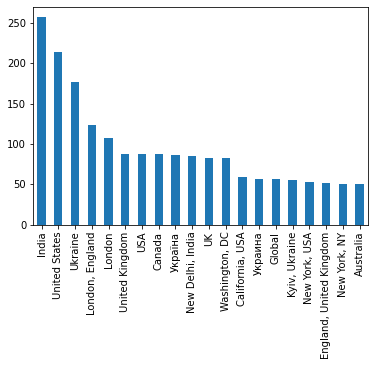

In [25]:
# Plot number of tweets based on location
df_feb.location.value_counts()[:20].plot.bar()

# Preprocess text data

In [26]:
# Plotting
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import matplotlib.pyplot as plt

def plot_word_cloud(column):
    

    # Check stopwords
    stopwords_set = set(STOPWORDS)
    wordcloud = WordCloud(background_color='white',
                          stopwords = stopwords_set,
                          max_words = 300,
                          max_font_size = 40,
                          scale = 2,
                          random_state=42
                         ).generate(str(column))
    plt.figure(figsize=(12, 8))

    print(wordcloud)
    plt.imshow(wordcloud)
    plt.axis('off')
    plt.show()

def data_cleaning(df):
    
    temp_df = df
    
    temp_df = temp_df.drop(['acctdesc', 'following', 'followers',
       'totaltweets', 'usercreatedts', 
       'retweetcount','favorite_count',
       'original_tweet_userid', 'original_tweet_username', 'in_reply_to_user_id', 'userid',
       'in_reply_to_screen_name', 'is_quote_status', 'quoted_status_id', 'original_tweet_id', 'in_reply_to_status_id',
       'quoted_status_userid', 'quoted_status_username', 'extractedts', 'coordinates', 'is_retweet', 'Unnamed: 0'], axis=1)
    
    # Drop these and check so no duplicates exists
    temp_df.drop_duplicates(["tweetid"], inplace=True)
    temp_df.duplicated(["tweetid"]).any()
    
    return temp_df

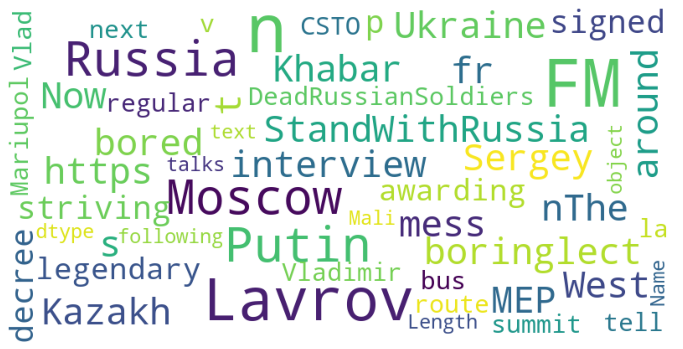

In [27]:
plot_word_cloud(df_russia['text'])
df_ukraine = data_cleaning(df_ukraine)
df_us = data_cleaning(df_us)
df_feb = data_cleaning(df_feb)
df_may = data_cleaning(df_may)
df_sep = data_cleaning(df_sep)

### We can see that the tweets contains a lot of links, hashtags, mentions, and emoji symbols.


# Preprocess data

In [28]:
import spacy
import re

nlp = spacy.load('en_core_web_sm', exclude=["ner","parser"])

def preprocess(text):
    
    # Remove https://-words, i.e., links
    text = re.sub(r'https?://\S+', '', text)
    
    doc = nlp(text)
    
    # Customized stopwords to remove html-format, mentions, and frequent used words that don't contribute to the topic modeling
    return [t.lemma_ for t in doc if (t.is_alpha and not t.is_stop and t.text.lower() not in ['amp', 'n','ukraine', 'russia', 
                                                                                              'russian', 'ukrainian'] and 
                                      len(t) > 2 and not t.text.startswith('@'))]

In [29]:
df_feb["cleaned_text"] = df_feb["text"].map(preprocess)
df_may["cleaned_text"] = df_may["text"].map(preprocess)
df_sep["cleaned_text"] = df_sep["text"].map(preprocess)
df_ukraine["cleaned_text"] = df_ukraine["text"].map(preprocess)
df_russia["cleaned_text"] = df_russia["text"].map(preprocess)
df_us["cleaned_text"] = df_us["text"].map(preprocess)

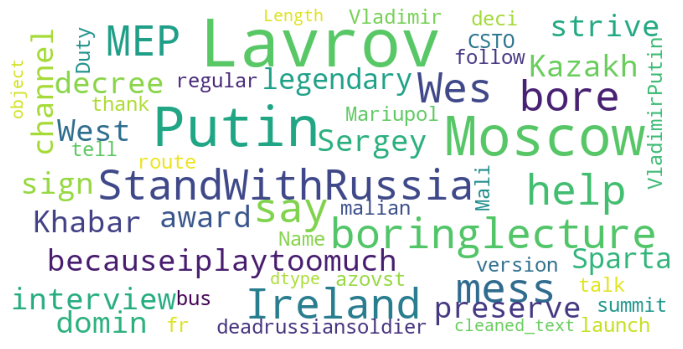

In [30]:
plot_word_cloud(df_russia['cleaned_text'])

# Latent Dirichlet Allocation (LDA)

In [38]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from pprint import pprint
import gensim
import warnings

warnings.filterwarnings('ignore', category=DeprecationWarning)
warnings.filterwarnings('ignore', category=FutureWarning)

def tune_lda_hyperparameter(corpus, dictionary, df):
    
    # Range of values for the num_topics and passes
    param_grid = {
        'num_topics': [5, 10, 15],
        'passes': [10, 20, 30]
    }

    # For storing each combination of hyperparameters
    scores = {}
    
    # For storing the coherence score and num_topics
    coherence_score = []

    # Iterate over all combinations of hyperparameter values
    for num_topics in param_grid['num_topics']:
        for passes in param_grid['passes']:
            
            # Train the model with the current combination of hyperparameter values
            
            lda_model = gensim.models.ldamodel.LdaModel(
                corpus=corpus,
                num_topics=num_topics,
                id2word=dictionary,
                passes=passes
            )
        
            # Evaluate the model
            coherence = gensim.models.coherencemodel.CoherenceModel(model=lda_model, texts=df['cleaned_text'], 
                                                                    dictionary=dictionary, coherence='c_v').get_coherence()
        
            # Store the coherence score in a dictionary
            scores[(num_topics, passes)] = coherence
            
            # Store the coherence score and num_topics
            coherence_score.append((num_topics, coherence))

    # Find the combination of hyperparameter values with highest coherence score
    best_num_topics, best_passes = max(scores, key=scores.get)

    # Print best hyperparameters
    print(f'Best hyperparameters: num_topics={best_num_topics}, passes={best_passes}')
    
    return best_num_topics, best_passes, coherence_score


def train_lda_model(df):
    
    nlp = spacy.load("en_core_web_sm")

    # Tokenize the text and extract the noun and verb tokens using part of speech tag
    noun_verb_tokens = []
    
    for sentence in df['cleaned_text']:
        
        doc = nlp(" ".join(sentence))
        noun_verb_tokens.append([token.text for token in doc if token.pos_ in ["NOUN", "VERB"]])

    # Create dictionary
    dictionary = gensim.corpora.Dictionary(noun_verb_tokens)

    # Create corpus
    corpus = [dictionary.doc2bow(tokens) for tokens in noun_verb_tokens]
    
    # Calculate optimal hyperparameters
    best_num_topics, best_passes, coherence_score = tune_lda_hyperparameter(corpus, dictionary, df)

    # Train LDA model using the optimal hyperparameters
    lda = gensim.models.ldamodel.LdaModel(
        corpus=corpus,
        num_topics=best_num_topics,
        id2word=dictionary,
        passes=best_passes
    )
    
    return lda, coherence_score, corpus

In [39]:
lda_russia, coherence_lda_russia, corpus_lda_russia = train_lda_model(df_russia)
lda_ukraine, coherence_lda_ukraine, corpus_lda_ukraine = train_lda_model(df_ukraine)
lda_us, coherence_lda_us, corpus_lda_us = train_lda_model(df_us)
lda_sep, coherence_lda_sep, corpus_lda_sep = train_lda_model(df_sep)
lda_may, coherence_lda_may, corpus_lda_may = train_lda_model(df_may)
lda_feb, coherence_lda_feb, corpus_lda_feb = train_lda_model(df_feb)

Best hyperparameters: num_topics=15, passes=30
Best hyperparameters: num_topics=5, passes=10
Best hyperparameters: num_topics=15, passes=20
Best hyperparameters: num_topics=15, passes=10
Best hyperparameters: num_topics=10, passes=10
Best hyperparameters: num_topics=15, passes=20


In [40]:
df_may.text[df_may['text'].str.contains('canadianbestseller')][0:5].values

array(['C$61.55 - #FreeShipping | Time is Running Out  OWC 4GB PC3-14900 DDR3 ECC 1866MHz SDRAM DIMM #OWC       👉 https://t.co/Q3FIC73cey       #sharious  #canadianbestseller  #canada #usa #product #1866MHz  #DDR3  #DIMM  #Module  #OWC1866D3ECC04G  #PC314900 . https://t.co/7szVwYb2Jg',
       'C$27.49 - #FreeShipping | Amazing deals at amazing low prices Umbra 28295279130 The Sinkin Dish Drying #Umbra       👉 https://t.co/NdWvsrjaIx       #sharious  #canadianbestseller  #canada #usa #product #28295279130  #Dish  #Drying  #Sinkin  #Umbra . https://t.co/r7MgAYJB0v',
       'C$16.86 - #FreeShipping | Biggest sale of the season  Luggage Strap, Wisdompro 2-Pack of Heavy Duty #wisdompro       👉 https://t.co/f6hD4yy2rl       #holiday #gifts #sharious  #canadianbestseller  #canada #usa #product #2Pack  #Accessories  #Adjustable . https://t.co/PxyvGofzNX',
       'C$13.74 - #FreeShipping | Shop with us today and enjoy up to 40%OFF!  Thick Dome Chunky Rings Set for Women Teen #FUTIMELY       👉 h

# Latent Semantic Analysis (LSA)

In [41]:

from gensim.models import LsiModel
from gensim import corpora


def tune_lsa_hyperparameter(bow, dictionary, df):
    
    # Range of values for the num_topics
    param_grid = {
        'num_topics': [5, 10, 15],
    }

    # For storing each combination of hyperparameters
    scores = {}
    
    # For storing the coherence score and num_topics
    coherence_score = []

    # Iterate over each num_topics value
    for num_topics in param_grid['num_topics']:
        
        # Train the LSA model with the current num_topic
        lsa_model = LsiModel(bow, num_topics=num_topics, id2word=dictionary)

        # Evaluate the model using the coherence score
        coherence = gensim.models.coherencemodel.CoherenceModel(model=lsa_model, texts=df['cleaned_text'], 
                                                                dictionary=dictionary, coherence='c_v').get_coherence()
        
        # Store the coherence score in the scores dictionary
        scores[(num_topics)] = coherence
        
        # Store the coherence score and num_topics
        coherence_score.append((num_topics, coherence))

    # Find the combination of hyperparameter values with highest coherence score
    best_num_topics = max(scores, key=scores.get)

    # Print best hyperparameter
    print(f'Best hyperparameter: num_topics={best_num_topics}')
    
    return best_num_topics, coherence_score



def train_lsa_model(df):
    
    nlp = spacy.load("en_core_web_sm")
    
    # Tokenize the text and extract the noun and verb tokens using part of speech tag
    noun_verb_tokens = []
    
    for sentence in df['cleaned_text']:
        
        doc = nlp(" ".join(sentence))
        noun_verb_tokens.append([token.text for token in doc if token.pos_ in ["NOUN", "VERB"]])
  
    # Create a dictionary with the corpus
    corpus = noun_verb_tokens
    dictionary = corpora.Dictionary(corpus)
    
    # Convert corpus into a bag of words
    bow = [dictionary.doc2bow(text) for text in corpus]
    
    n_topics, coherence_score = tune_lsa_hyperparameter(bow, dictionary, df)
    
    # Perform LSA using LsiModel and the best number of topic
    lsa = LsiModel(bow, num_topics=n_topics, id2word=dictionary)
    
    return lsa, coherence_score, corpus

In [42]:
lsa_russia, coherence_lsa_russia, corpus_lsa_russia = train_lsa_model(df_russia)
lsa_ukraine, coherence_lsa_ukraine, corpus_lsa_ukraine = train_lsa_model(df_ukraine)
lsa_us, coherence_lsa_us, corpus_lsa_us = train_lsa_model(df_us)
lsa_sep, coherence_lsa_sep, corpus_lsa_sep = train_lsa_model(df_sep)
lsa_may, coherence_lsa_may, corpus_lsa_may = train_lsa_model(df_may)
lsa_feb, coherence_lsa_feb, corpus_lsa_feb = train_lsa_model(df_feb)

Best hyperparameter: num_topics=10
Best hyperparameter: num_topics=5
Best hyperparameter: num_topics=10
Best hyperparameter: num_topics=10
Best hyperparameter: num_topics=5
Best hyperparameter: num_topics=10


# Validation

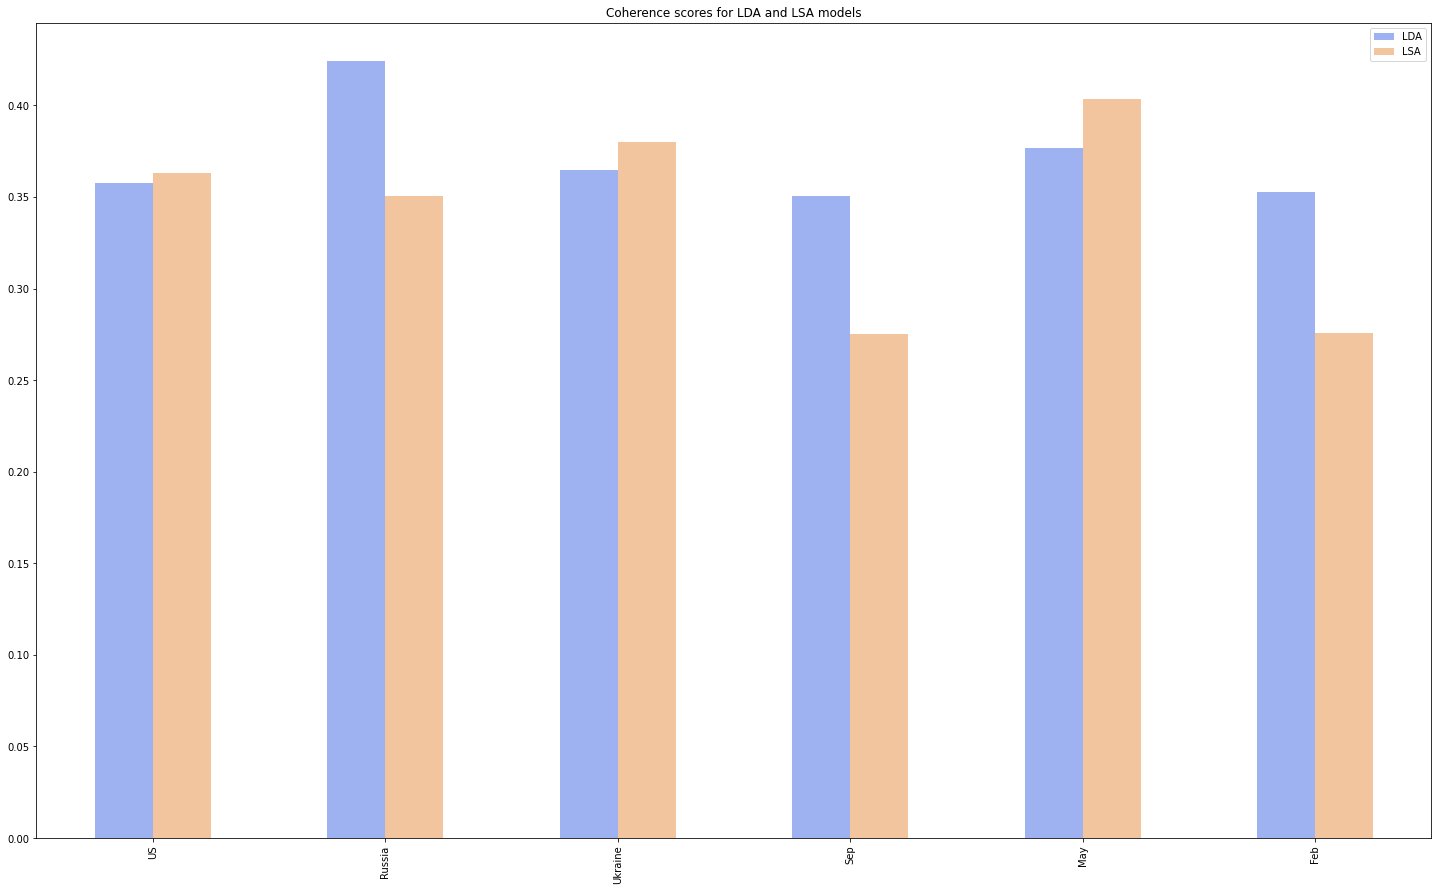

In [49]:
import seaborn as sns

# Create a list of datasets
datasets = ['US', 'Russia', 'Ukraine', 'Sep', 'May', 'Feb']
coherence_scores_lda = [coherence_lda_us, coherence_lda_russia, coherence_lda_ukraine, coherence_lda_sep, 
                        coherence_lda_may, coherence_lda_feb]
coherence_scores_lsa = [coherence_lsa_us, coherence_lsa_russia, coherence_lsa_ukraine, coherence_lsa_sep, 
                        coherence_lsa_may, coherence_lsa_feb]

max_coherence_scores_lda = [max(coherence_scores, key=lambda x: x[1])[1] for coherence_scores in coherence_scores_lda]
max_coherence_scores_lsa = [max(coherence_scores, key=lambda x: x[1])[1] for coherence_scores in coherence_scores_lsa]

# Create a dataframe with the coherence scores for LDA and LSA
df = pd.DataFrame({'LDA': max_coherence_scores_lda, 'LSA': max_coherence_scores_lsa}, index=datasets)

# Set the color palette for the bar plot
sns.set_palette(["#9EB2F2", "#F2C59E"])

# Create the bar plot
ax = df.plot.bar(figsize=(25, 15))

# Set the title
plt.title('Coherence scores for LDA and LSA models')

# Show the plot
plt.show()


In [44]:
from sklearn.manifold import TSNE
from bokeh.plotting import figure, output_file, show
from bokeh.models import Label
from bokeh.io import output_notebook
from bokeh.palettes import Category20
from bokeh.models import Legend

# Get the topic weights for each document
doc_topic_weights = lda_russia.get_document_topics(corpus_lda_russia, minimum_probability=0)

# Get the weights for each topic
topic_weights = []
for i, row in enumerate(doc_topic_weights):
    topic_weights.append([w for _, w in row])

# Use TSNE to reduce the dimensionality of the topic weights
tsne = TSNE(n_components=2)
topic_weights_tsne = tsne.fit_transform(topic_weights)

# Plot the Topic Clusters using Bokeh
output_notebook()

# Get the number of topics
n_topics = lda_russia.num_topics

# Create a color palette with a different color for each topic
colors = Category20[n_topics]

plot = figure(title="t-SNE Clustering of {} LDA Topics".format(n_topics), 
              plot_width=900, plot_height=700)
plot.scatter(x=topic_weights_tsne[:, 0], y=topic_weights_tsne[:, 1],
             color=[colors[i] for i in np.argmax(topic_weights, axis=1)])

# Create a list of legend items
legend_items = []
for i in range(n_topics):
    legend_items.append((f"Topic {i}", [plot.circle(x=0, y=0, fill_color=colors[i], line_color=None)]))

# Create the legend
legend = Legend(items=legend_items)

# Add the legend to the plot
plot.add_layout(legend)

show(plot)

Loading BokehJS ...

In [3]:
def print_words(model):
    
    for topic_id in range(model.num_topics):
        topk = model.show_topic(topic_id, 10)
        topk_words = [ w for w, _ in topk ]
    
        print('{}: {}'.format(topic_id, ' '.join(topk_words)))

In [51]:
print('Top words LDA Russia dataset:')
print_words(lda_russia)
print('Top words LSA Russia dataset:')
print_words(lsa_russia)

Top words LDA Russia dataset:
0: missile destroy strike work attack position region direction enemy system
1: meeting hold state visit meet power talk arrive plant issue
2: city continue battle remember burn turn village center thank day
3: fire report child breaking house set entertainment recount arrival shelling
4: stop weapon say kill lie infrastructure go supply child energy
5: day week force today come thing history crime conflict year
6: use capture training troop watch weapon combat account develop group
7: perman time try hour evening increase hand movie timing telecast
8: video regiment soldier foot support send life army publish fighter
9: sanction year oil receive price gas love number question food
10: tell plan bridge know car look rocket train bomb drop
11: war people country lose need want help day die speak
12: news government think start live take talk panpacificagency people peace
13: operation report air progress sky ask event read wind degree
14: gun machine shoot 

In [52]:
print('Top words LDA Ukraine dataset:')
print_words(lda_ukraine)
print('Top words LSA Ukraine dataset:')
print_words(lsa_ukraine)

Top words LDA Ukraine dataset:
0: support thank war standwithukraine country work say live aid sanction
1: help need animal food stop fund weapon raise shelter cat
2: soldier russianwarcrime troop region territory ukraineunderattack standwithukraine fight video force
3: war child victory people world eye russiaisaterroriststate stop IStandWithUkraine prayforukraine
4: destroy region missile attack city people day fire kill hit
Top words LSA Ukraine dataset:
0: help animal need war food fund raise shelter cat people
1: war people animal kill child fund food raise cat shelter
2: war kill people region child missile support attack city russiaisaterroriststate
3: child victory eye region IStandWithUkraine prayforukraine kill missile city attack
4: people region support missile war child destroy city attack thank


In [53]:
print('Top words LDA US dataset:')
print_words(lda_us)
print('Top words LDA US dataset:')
print_words(lsa_us)

Top words LDA US dataset:
0: say inflation live News economy stock hear week lose cause
1: man order aid stand election reason guy propaganda putinwarcrime expect
2: war year win watch tell happen end see rtitbot base
3: war book peace follow hold remember get offer start ebook
4: attack spin missile strike kill fire report destroy hit tank
5: people support stop country think know need fight woman let
6: price oil talk standwithukraine gas ask leave usd family point
7: world look hope wait bring care job stay beat loss
8: video force city read invasion join border soldier area issue
9: help donate consider cryptocurrency crypto stoprussianaggression patron time nft morning
10: news crime Monsters break trend share trump speak show town
11: business pay vote class warinukraine deal help stopputinnow sign assignment
12: want money day sanction face give control take trade blame
13: send weapon thank death work use sale kid number time
14: russiaisaterroriststate visit sell ukraineinvasi

In [54]:
print('Top words LDA February dataset:')
print_words(lda_feb)
print('Top words LSA February dataset:')
print_words(lsa_feb)

Top words LDA February dataset:
0: country take say war tell get allow UkraineRussiaWar give order
1: child fight leave people woman border student kill home food
2: help sanction donate family refugee way word bring play care
3: man look talk read government face lose show happen thing
4: people want world war think country year history standwithukraine find
5: soldier break today army end conflict war ukrainerussiacrisis video update
6: stop russianukrainianwar SKY work ukrainerussiawar stopputinnow save suspend putinwarcrime murder
7: war thank attack crime humanity try friend remember company cost
8: stop need weapon provide defend death safeairliftukraine assistance sky help
9: war go start know oil RussiaUkraineWar day gas stop love
10: send power use troop russianinvasion plant stopwarinukraine invade stoprussianaggression plan
11: support stand ukraineunderattack people time follow wait set turn energy
12: city bomb kill destroy missile air ukrainerussianwar force fire tank
13:

In [61]:
print('Top words LDA May dataset:')
print_words(lda_may)
print('Top words LSA May dataset:')
print_words(lsa_may)

Top words LDA May dataset:
0: business market crypto nftcommunity nft stand video sale marketing trend
1: tank soldier save force government tell claim deal defend capture
2: invest business stock finance product vote canadianbestseller comment eurovision change
3: business money art work thank look know need build freelancer
4: news health sign BreakingNews election say hope bodyhealth project healthtip
5: war stop fight start win say want troop support country
6: people think world war food break country time russianwarcrime need
7: region child go supply destroy aid day need school kill
8: join love pay help business history game hear read story
9: news say law lawyer play sanction attorney report gas inflation
Top words LSA May dataset:
0: business news invest finance stock help war startup entrepreneur marketing
1: news business war say law lawyer attorney health invest people
2: war news people world country stop say business support help
3: war people invest help country stock w

In [60]:
print('Top words LDA September dataset:')
print_words(lda_sep)
print('Top words LSA September dataset:')
print_words(lsa_sep)

Top words LDA September dataset:
0: soldier kill destroy attack tank people drone talk win fire
1: russiaisaterroriststate standwithukraine play hit month pay flag loss decide mobilisation
2: look video love watch show member night check run map
3: war world country support stop think people peace end start
4: know want tell get thing sign day live lie people
5: break news join sanction self twitter issue position election person
6: threat regime fall ukrainerussiawar stand school military head say group
7: weapon use war crime see enemy turn push ally winter
8: man woman lose bring RussiaUkraineWar child art buy armukrainenow mobilize
9: say force territory leave city border region troop land line
10: gas report pipeline oil sabotage energy price article blow supply
11: region referendum vote mobilization hold area territory annex law protest
12: today work take life war history go make fact care
13: help people need follow time russiaisateroriststate save surrender problem murder
14: